## load dataset

In [1]:
# # Install necessary packages
# !pip install kaggle gdown

# Download Kaggle API token from Google Drive
gdrive_url = 'https://drive.google.com/uc?id=1P6t7O8vOjmQi3rMX0KQlgO6BT0fk2dI-'

# Configure the Kaggle API
import os
from pathlib import Path

import gdown
if not os.path.exists('kaggle.json'):
    gdown.download(gdrive_url, 'kaggle.json', quiet=False)

kaggle_dir = Path.home() / '.kaggle'
kaggle_token_path = kaggle_dir / 'kaggle.json'

if not kaggle_token_path.exists():
    # Create the .kaggle directory if it does not exist
    kaggle_dir.mkdir(parents=True, exist_ok=True)

    # Move the kaggle.json to ~/.kaggle/
    os.rename('kaggle.json', kaggle_token_path)

    # Set the permissions to read and write for the user only
    kaggle_token_path.chmod(0o600)

dataset_path = 'A_Z Handwritten Data.csv'

if not os.path.exists(dataset_path):
    # Download the dataset from Kaggle
    kaggle_remote_path = 'sachinpatel21/az-handwritten-alphabets-in-csv-format'
    !kaggle datasets download -d {kaggle_remote_path} --unzip

import pandas as pd
data = pd.read_csv(dataset_path)
display(data.head())
print('data shape:', data.shape)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


data shape: (372450, 785)


In [2]:
# Define the kana characters and their corresponding labels
letters = [chr(i) for i in range(65, 91)]
print(letters)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## validate and visualize dataset

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import matplotlib.pyplot as plt # plotting
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [4]:
num_samples = 372450
num_classes = 26  # Number of letters in the alphabet

# data.insert(0, 'alphabet', np.random.randint(0, num_classes, size=num_samples))

# Add column names
columns = ['alphabet'] + [f'pixel_{i}' for i in range(1, 785)]
data.columns = columns
data.columns

Index(['alphabet', 'pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5',
       'pixel_6', 'pixel_7', 'pixel_8', 'pixel_9',
       ...
       'pixel_775', 'pixel_776', 'pixel_777', 'pixel_778', 'pixel_779',
       'pixel_780', 'pixel_781', 'pixel_782', 'pixel_783', 'pixel_784'],
      dtype='object', length=785)

In [5]:
from tensorflow.keras.utils import to_categorical

# X = np.random.randint(0, 256, size=(num_samples, 784))
# y = np.random.randint(0, num_classes, size=(num_samples,))
# X = X.reshape(-1, 28, 28, 1)
# X = X / 255.0
# y = to_categorical(y, num_classes)
y = data['alphabet']
X = data.drop('alphabet', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape,

((260715, 784), (111735, 784))

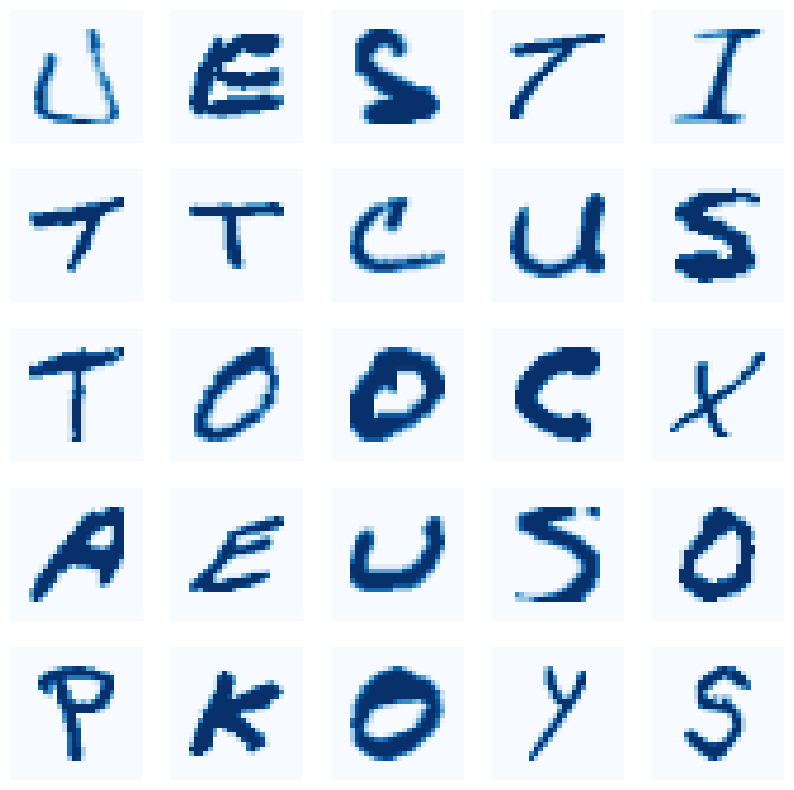

In [6]:
import numpy as np

random_indices = np.random.choice(range(len(X)), size=25, replace=False)
_, axes = plt.subplots(5, 5, figsize=(10, 10))
for i,ax in enumerate(axes.ravel()):
    ax.imshow(X.iloc[random_indices[i]].values.reshape(28, 28), cmap='Blues')
    ax.axis('off')
plt.show()

## build and train model

In [7]:
# model with 1d convolution

from tensorflow.keras import layers

cnn = tf.keras.models.Sequential([
    layers.InputLayer(shape=(X_train.shape[1],)),
    tf.keras.layers.Reshape((X_train.shape[1], 1)),  # Reshape to (784, 1)
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') # try using linear
], name='one_dimensional_cnn')
# research difference between from_logits=False and from_logits=True
cnn.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
cnn.summary()

# Train the model
epochs = 10 # change to 10 during production
history_cnn = cnn.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))
history_cnn.history['name'] = cnn.name

# Evaluate the model
test_loss, test_accuracy = cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Model: "one_dimensional_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 784, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 782, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 391, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 389, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 194, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,589,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,599,066 (6.10 MB)

 Trainable params: 1,599,066 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 168s 20ms/step - accuracy: 0.4982 - loss: 2.0766 - val_accuracy: 0.9252 - val_loss: 0.2806
Epoch 2/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 167s 21ms/step - accuracy: 0.8392 - loss: 0.5523 - val_accuracy: 0.9533 - val_loss: 0.1688
Epoch 3/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 168s 21ms/step - accuracy: 0.9025 - loss: 0.3394 - val_accuracy: 0.9642 - val_loss: 0.1300
Epoch 4/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 175s 21ms/step - accuracy: 0.9221 - loss: 0.2671 - val_accuracy: 0.9684 - val_loss: 0.1150
Epoch 5/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 177s 22ms/step - accuracy: 0.9353 - loss: 0.2204 - val_accuracy: 0.9704 - val_loss: 0.1076
Epoch 6/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 185s 23ms/step - accuracy: 0.9427 - loss: 0.1898 - val_accuracy: 0.9739 - val_loss: 0.0941
Epoch 7/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 191s 23ms/step - accuracy: 0.9487 - loss: 0.1682 - val_accuracy: 0.9759 - val_loss: 0.0891
Epoch 8/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 210s 24ms/step - accuracy: 

In [8]:
# multilayer perceptron without convolution

mlp = tf.keras.models.Sequential(name='multilayer_perceptron')
mlp.add(layers.InputLayer(shape=(X_train.shape[1],)))
mlp.add(layers.Dense(128, activation='relu'))
mlp.add(layers.Dense(64, activation='relu'))
mlp.add(layers.Dense(26, activation='softmax')) # try using linear
mlp.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
mlp.summary()

epochs = 10 # change to 10 during production
history_mlp = mlp.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))
history_mlp.history['name'] = mlp.name

# Evaluate the model after training
test_loss, test_accuracy = mlp.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Model: "multilayer_perceptron"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,426 (431.35 KB)

 Trainable params: 110,426 (431.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


c:\Users\duterte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8143/8148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4581 - loss: 9.6824

c:\Users\duterte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8148/8148 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.4582 - loss: 9.6778 - val_accuracy: 0.7596 - val_loss: 1.0062
Epoch 2/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7914 - loss: 0.8535 - val_accuracy: 0.8548 - val_loss: 0.5509
Epoch 3/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8781 - loss: 0.4590 - val_accuracy: 0.9099 - val_loss: 0.3517
Epoch 4/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9175 - loss: 0.3061 - val_accuracy: 0.9293 - val_loss: 0.2718
Epoch 5/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9376 - loss: 0.2255 - val_accuracy: 0.9395 - val_loss: 0.2336
Epoch 6/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9488 - loss: 0.1837 - val_accuracy: 0.9496 - val_loss: 0.1943
Epoch 7/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9555 - loss: 0.1553 - val_accuracy: 0.9534 - val_loss: 0.1793
Epoch 8/10
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9618 - loss: 0.1328 - val

## evaluate training loss and plot confusion matrix

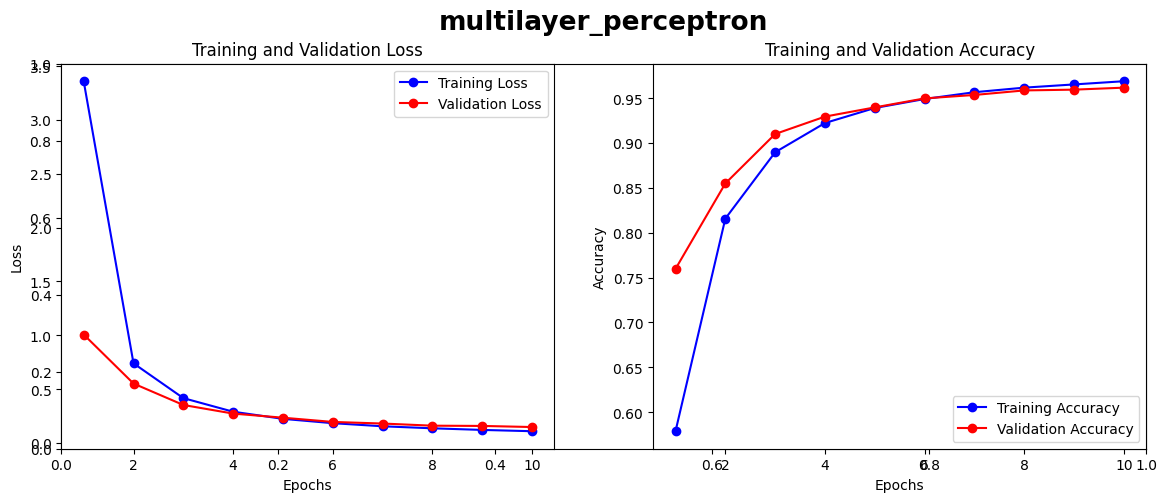

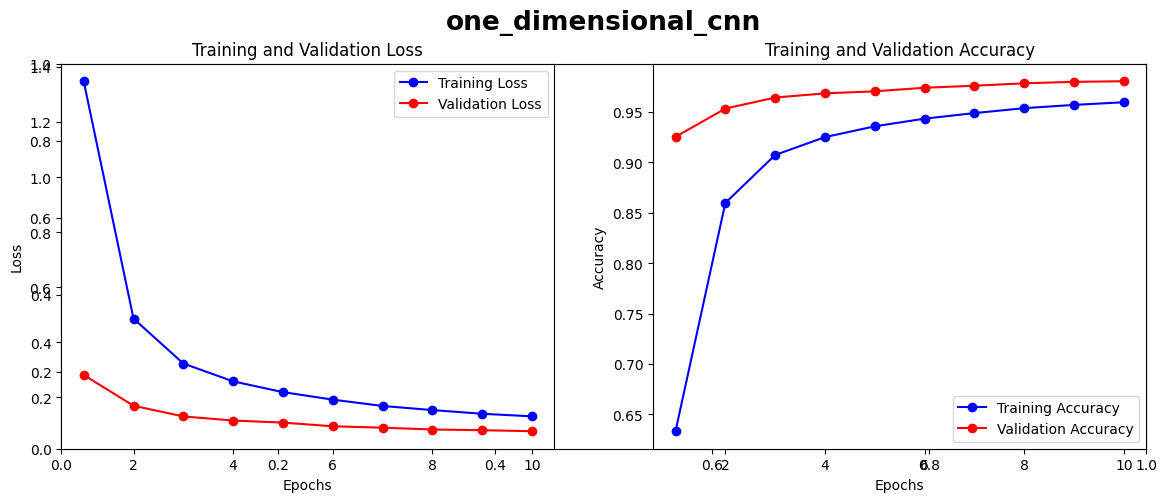

In [9]:
for history in [h.history for h in [history_mlp, history_cnn]]:
    # Extracting loss and accuracy
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    title = history['name']
    epochs = range(1, len(train_loss) + 1)

    # Plotting training and validation loss
    plt.figure(figsize=(14, 5))
    plt.title(title, fontsize=19, weight='bold', pad=25)

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

3492/3492 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step


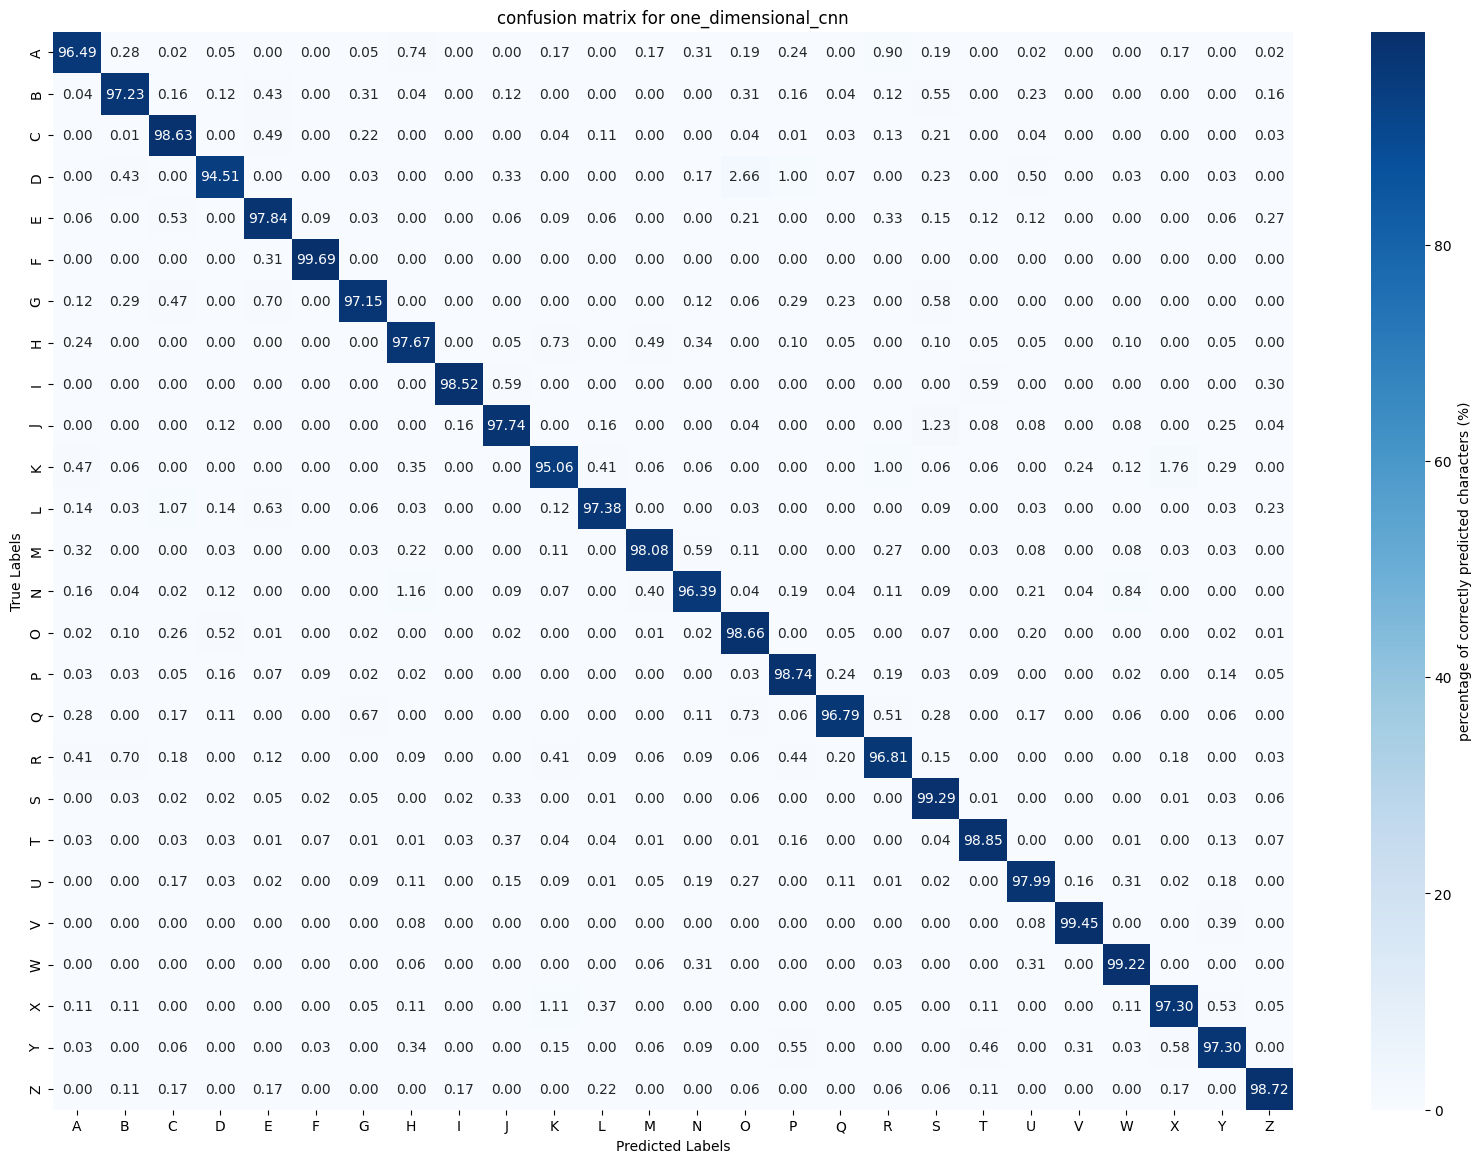

3492/3492 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


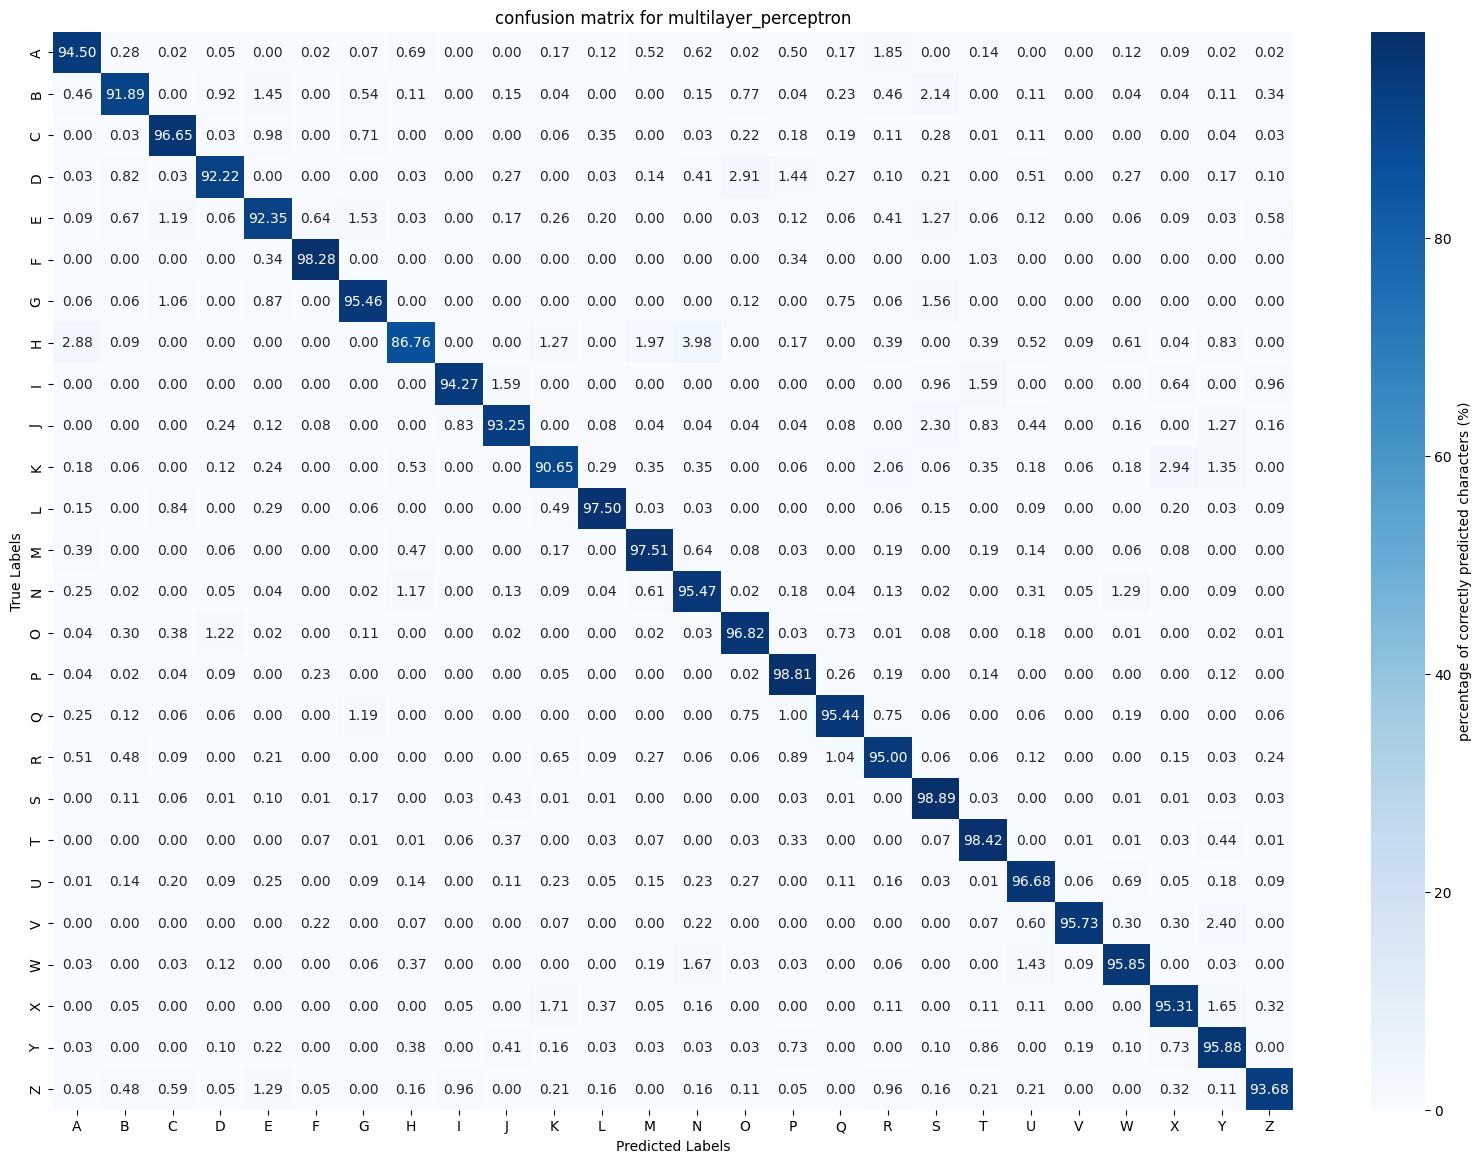

In [10]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for model in [cnn, mlp]:
    y_pred = tf.argmax(model.predict(X_test), axis=1).numpy()

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_pred, y_test)
    # normalize to scale from 0 to 100 in terms of row precision
    normalized_matrix = np.array([[i/sum(row)*100 for i in row] for row in conf_matrix])

    # Convert confusion matrix to DataFrame for better visualization
    normalized_df = pd.DataFrame(normalized_matrix,
                                index=[f'{letters[i]}' for i in range(normalized_matrix.shape[0])],
                                columns=[f'{letters[i]}' for i in range(normalized_matrix.shape[1])])

    # Plot the confusion matrix
    plt.figure(figsize=(20, 14))
    sns.heatmap(normalized_df, annot=True, fmt='.2f', cmap='Blues', cbar_kws={
        'label': 'percentage of correctly predicted characters (%)'}
    )
    plt.title('confusion matrix for ' + model.name)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

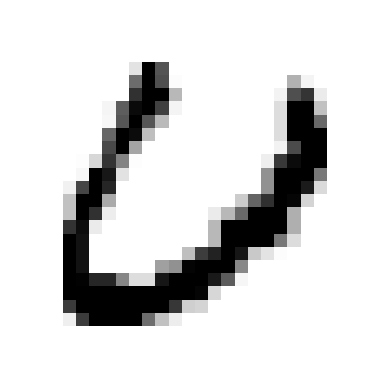

inferencing...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted character: U


In [11]:
# bonus: utilize the better model (CNN) for predicting characters

import random
index = random.randint(0,len(X_test))

plt.imshow(X_test.iloc[index].values.reshape(28, 28), cmap='Grays')
plt.axis('off')
plt.show()

print('inferencing...')
out = letters[tf.argmax(cnn.predict(np.expand_dims(np.array(X_test.iloc[index]),axis=0)),axis=1).numpy()[0]]
print('predicted character:', out)